# Generic forecast skill

This notebook contains plot showing the skill of commonly assessed variables and metrics. Results are shown for CAFE-f6 and for the CanESM5 and EC-Earth3 CMIP6 DCPP submissions. 30-year climatological and verification periods are used for both the CAFE-f6 and CMIP6 data. However, because the historical CMIP6 data end in 2014, these periods differ slightly: 1991-2020 for CAFE-f6; 1985-2014 for CanESM5 and EC-Earth3.

If you wish to see anything added to these results, please contact Dougie

In [1]:
import cftime

import xarray as xr
import xskillscore as xs

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from src import plot

In [3]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [4]:
def plot_skill_maps(
    hindcasts,
    reference,
    variable,
    metric,
    cafe_anom_period="1991-2020",
    cafe_verif_period="1991-2020",
    dcpp_anom_period="1985-2014",
    dcpp_verif_period="1985-2014",
):
    """
    Helper function for plotting some skill maps. Edit this function to change which
    lead times are plotted
    """

    def _load_skill(hindcast, reference, timescale, variable, metric):
        """Load a skill metric"""
        SKILL_DIR = "../../data/skill/"
        if hindcast == "CAFEf6":
            anom_period = cafe_anom_period
            verif_period = cafe_verif_period
        else:
            anom_period = dcpp_anom_period
            verif_period = dcpp_verif_period
        file = (
            f"{SKILL_DIR}/{hindcast}.{reference}.{timescale}.anom_{anom_period}"
            f".{variable}.{metric}_{verif_period}.zarr"
        )
        return xr.open_zarr(file).compute()

    fields = []
    headings = []
    for hindcast in hindcasts:
        annual = _load_skill(hindcast, reference, "annual", variable, metric)
        quadrennial = _load_skill(hindcast, reference, "4-year", variable, metric)

        # Change this to change what leads are plotted
        to_plot = {
            "year 1": annual.sel(lead=23),
            "years 1-4": quadrennial.sel(lead=59),
            "years 5-8": quadrennial.sel(lead=107),
        }
        fields.append(list(to_plot.values()))
        headings.append(
            [f"{hindcast} | {metric} | {timescale}" for timescale in to_plot.keys()]
        )

    if len(hindcasts) >= 3:
        figsize = (15, 9.1)
    elif len(hindcasts) == 2:
        figsize = (15, 6.1)
    else:
        figsize = (15, 3.2)
    return plot.skill_maps(
        fields, variable=variable, vrange=(-1, 1), headings=headings, figsize=figsize
    )

## Sea surface temperature
### Anomaly correlation coefficient  |  HadISST

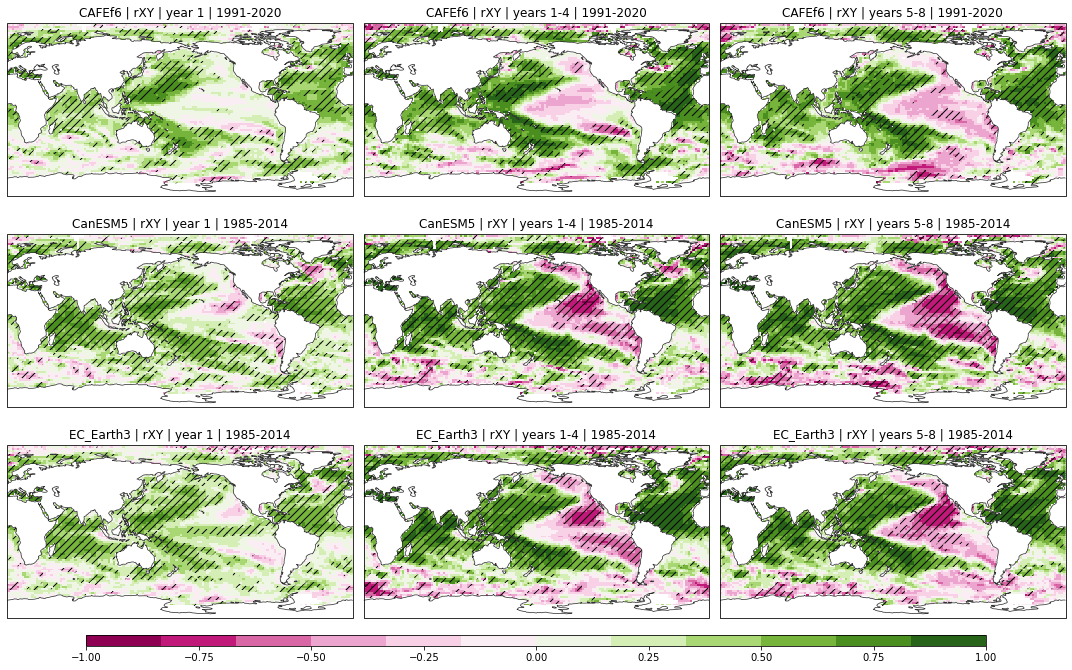

In [5]:
_ = plot_skill_maps(["CAFEf6", "CanESM5", "EC_Earth3"], "HadISST", "sst", "rXY")

#### What are those big patches of negative correlation in the Pacific the 4-year averages?
These aren't apparent in the CanESM5 verification paper. Are they an artifact of differing "trends" over the short verifcation period? Let's look at the skill of CanESM5 and EC_Earth3 over a longer (1971-2017) period of time

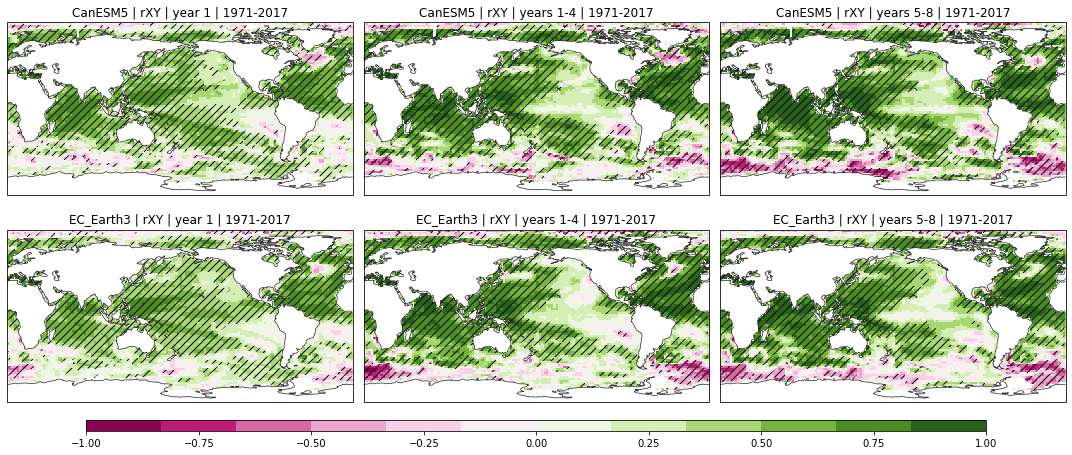

In [6]:
_ = plot_skill_maps(
    ["CanESM5", "EC_Earth3"], "HadISST", "sst", "rXY", dcpp_verif_period="1971-2017"
)

This looks more like the results in the CanESM5 verification paper. So we need to be pretty careful interpretting the anomaly correlation coefficient over our short verification period. Let's demonstrate this by looking at the hindcast and observed timeseried at a location in the Pacific:

In [7]:
location = dict(lon=225, lat=10)
full_period = slice("1971", "2017")
verif_period = slice("1985", "2014")

hcst = xr.open_zarr("../../data/processed/CanESM5.4-year.anom_1985-2014.sst.zarr").sel(
    location, method="nearest"
)
hcst = (
    hcst["sst"]
    .mean("member")
    .sel(lead=59)
    .swap_dims({"init": "time"})
    .sel(time=full_period)
)

obsv = xr.open_zarr("../../data/processed/HadISST.4-year.anom_1985-2014.sst.zarr").sel(
    location, method="nearest"
)
obsv = obsv["sst"].sel(time=hcst.time)

acc_full_period = xs.pearson_r(hcst, obsv, dim="time").values.item()

acc_verif_period = xs.pearson_r(
    hcst.sel(time=verif_period), obsv.sel(time=verif_period), dim="time"
).values.item()

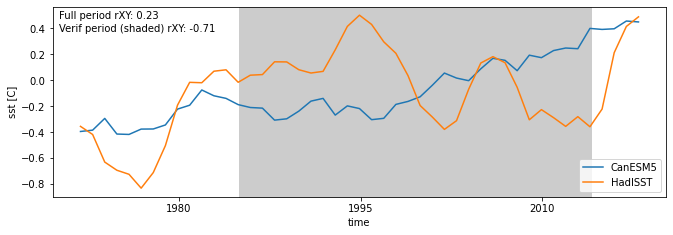

In [8]:
fig, ax = plt.subplots(figsize=(11, 3.5))

hcst.plot(label="CanESM5")
obsv.plot(label="HadISST")
ylim = plt.gca().get_ylim()
plt.fill_between(
    [cftime.datetime(1985, 1, 1), cftime.datetime(2014, 1, 1)],
    [ylim[0], ylim[0]],
    [ylim[1], ylim[1]],
    color=[0.8, 0.8, 0.8],
)
plt.gca().set_ylim(ylim)
plt.title("")
plt.legend(loc="lower right")

plt.text(
    0.01,
    0.98,
    f"Full period rXY: {acc_full_period:.2f}",
    horizontalalignment="left",
    verticalalignment="top",
    transform=ax.transAxes,
)
_ = plt.text(
    0.01,
    0.91,
    f"Verif period (shaded) rXY: {acc_verif_period:.2f}",
    horizontalalignment="left",
    verticalalignment="top",
    transform=ax.transAxes,
)

### Initialised component of the anomaly correlation coefficient | HadISST 
(see https://doi.org/10.1029/2019GL086361)

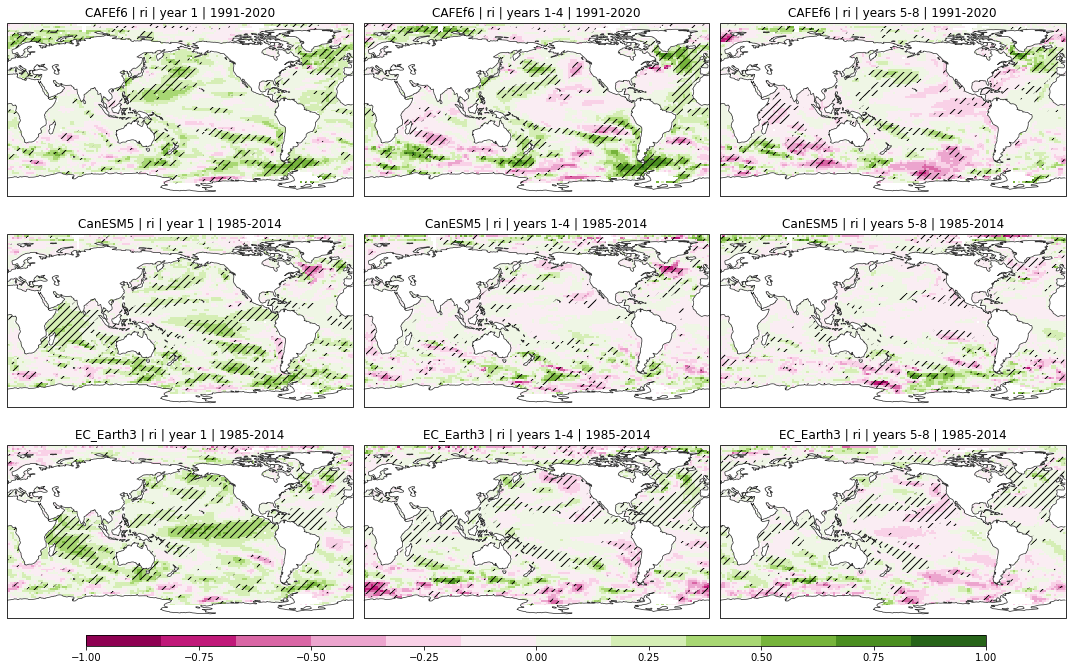

In [9]:
_ = plot_skill_maps(["CAFEf6", "CanESM5", "EC_Earth3"], "HadISST", "sst", "ri")

### Mean squared skill score relative to historical simulations | HadISST

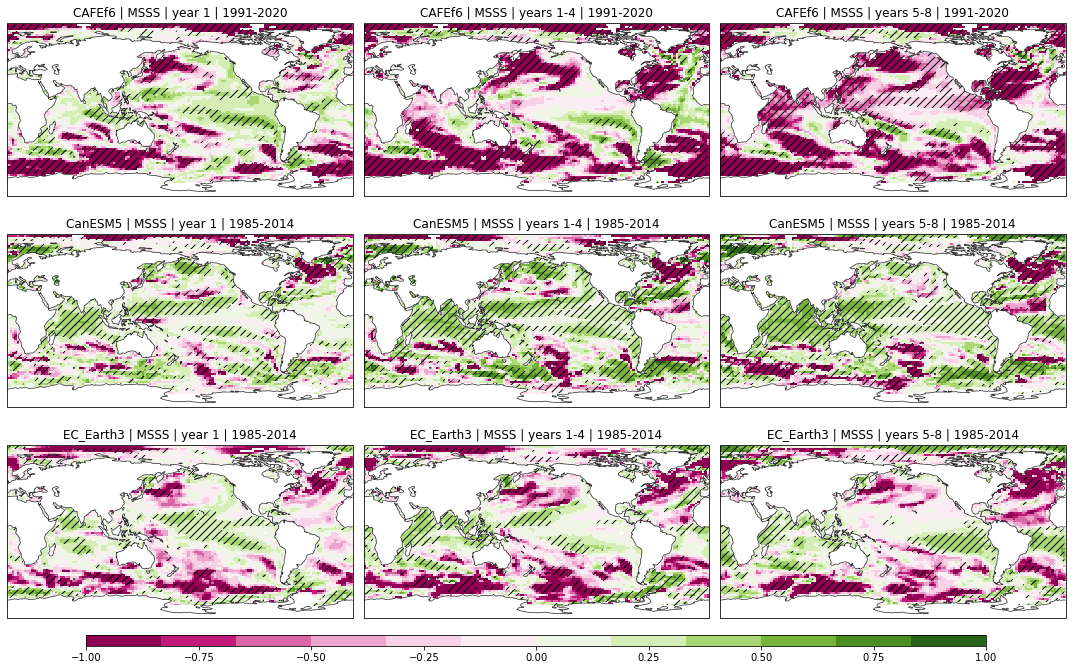

In [10]:
_ = plot_skill_maps(["CAFEf6", "CanESM5", "EC_Earth3"], "HadISST", "sst", "MSSS")

### Rank probability skill score relative to historical simulations | HadISST

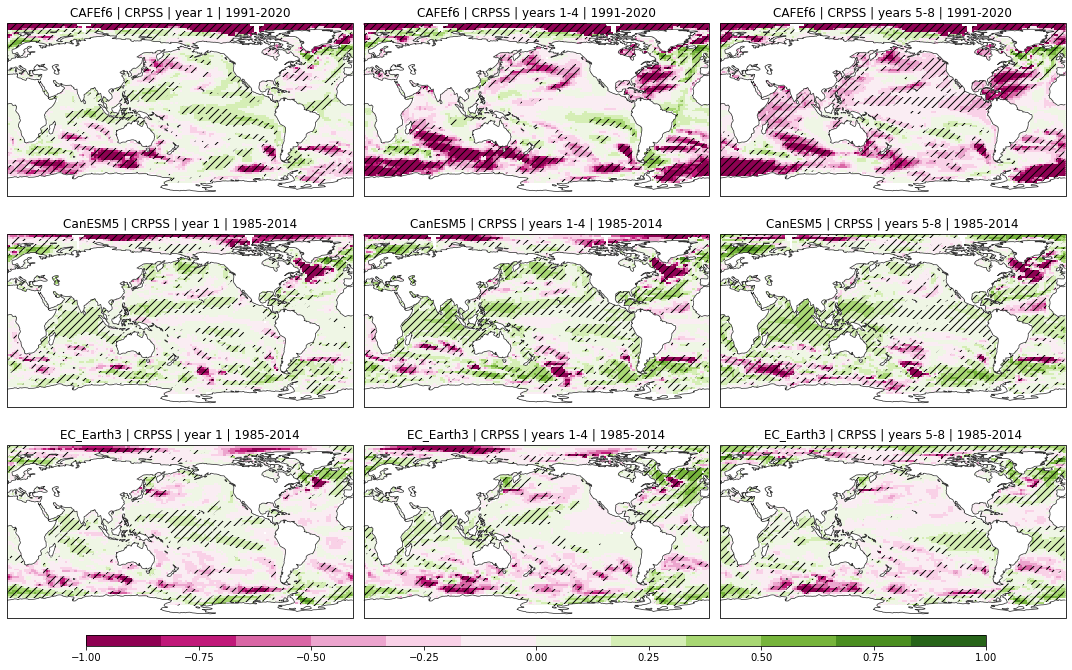

In [11]:
_ = plot_skill_maps(["CAFEf6", "CanESM5", "EC_Earth3"], "HadISST", "sst", "CRPSS")

## Near-surface (2m) temperature
### Anomaly correlation coefficient  |  JRA55

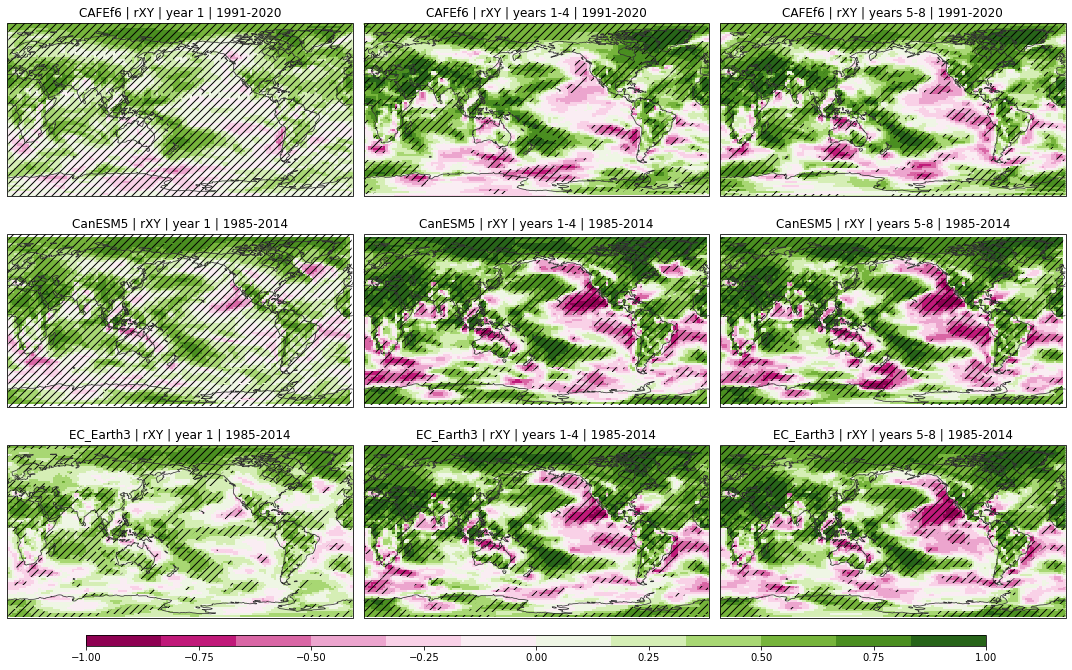

In [12]:
_ = plot_skill_maps(["CAFEf6", "CanESM5", "EC_Earth3"], "JRA55", "t_ref", "rXY")

### Initialised component of the anomaly correlation coefficient | JRA55 
(see https://doi.org/10.1029/2019GL086361)

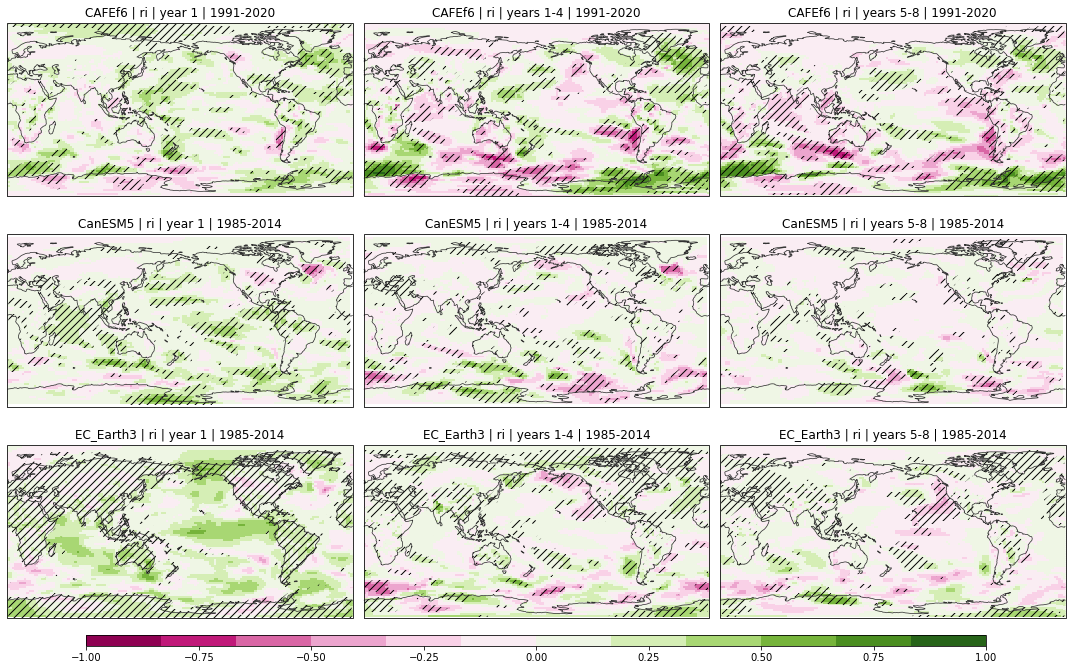

In [13]:
_ = plot_skill_maps(["CAFEf6", "CanESM5", "EC_Earth3"], "JRA55", "t_ref", "ri")

### Mean squared skill score relative to historical simulations | JRA55

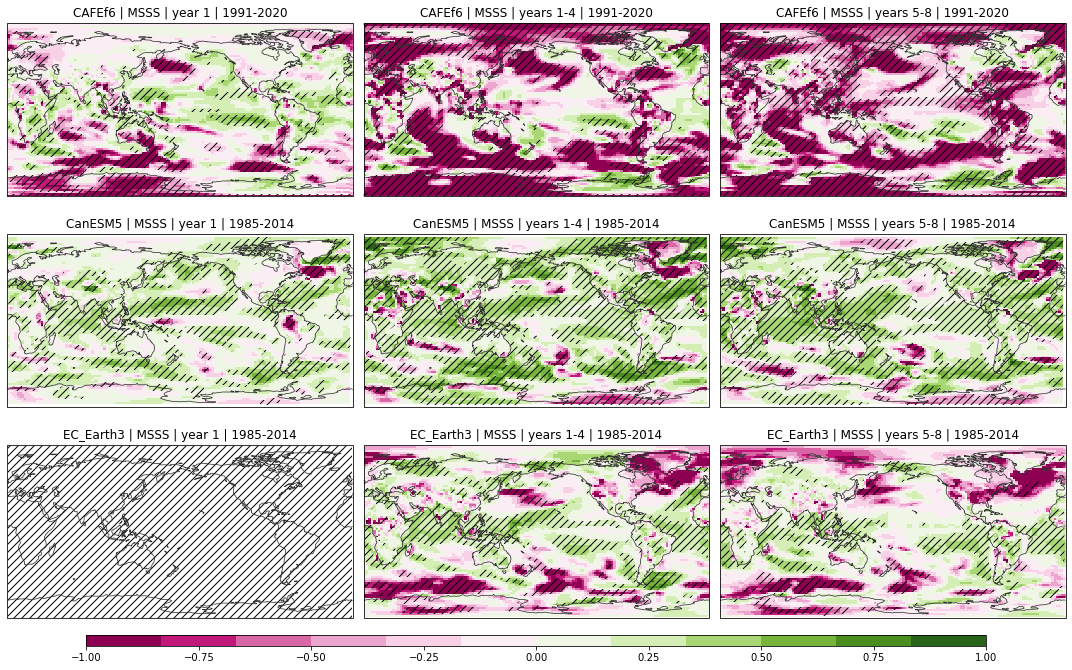

In [14]:
_ = plot_skill_maps(["CAFEf6", "CanESM5", "EC_Earth3"], "JRA55", "t_ref", "MSSS")

### Rank probability skill score relative to historical simulations | JRA55

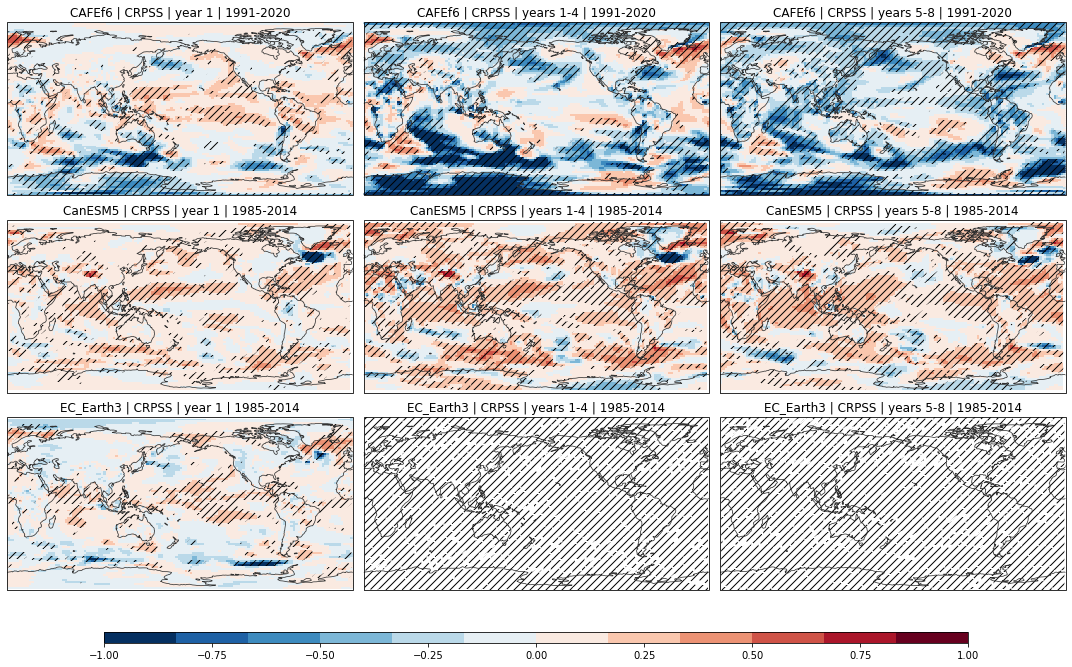

In [61]:
_ = plot_skill_maps(["CAFEf6", "CanESM5", "EC_Earth3"], "JRA55", "t_ref", "CRPSS")

## Precipitation
### Anomaly correlation coefficient  |  GPCP

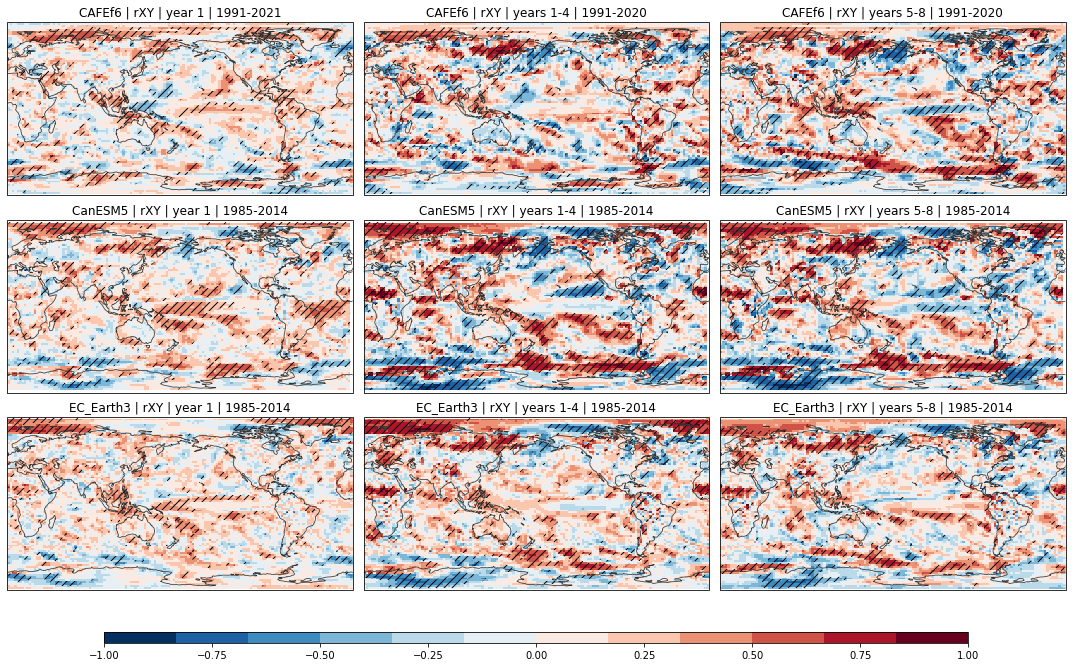

In [71]:
_ = plot_skill_maps(["CAFEf6", "CanESM5", "EC_Earth3"], "GPCP", "precip", "rXY")

### Initialised component of the anomaly correlation coefficient | GPCP 
(see https://doi.org/10.1029/2019GL086361)

Exception ignored in: Traceback (most recent call last):
'pyproj._datadir.pyproj_log_function'
Traceback (most recent call last):
  File "/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/logging/__init__.py", line 1424, in debug
  File "/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/logging/__init__.py", line 1424, in debug
    def debug(self, msg, *args, **kwargs):
KeyboardInterrupt
    def debug(self, msg, *args, **kwargs):
KeyboardInterrupt: 


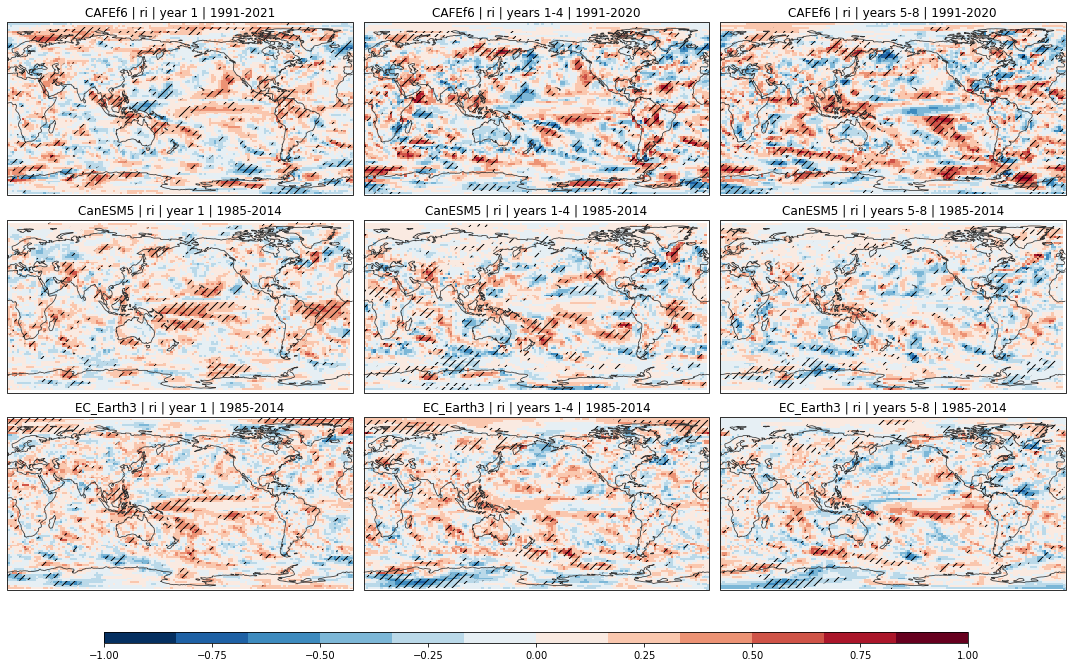

In [72]:
_ = plot_skill_maps(["CAFEf6", "CanESM5", "EC_Earth3"], "GPCP", "precip", "ri")

### Mean squared skill score relative to historical simulations | GPCP

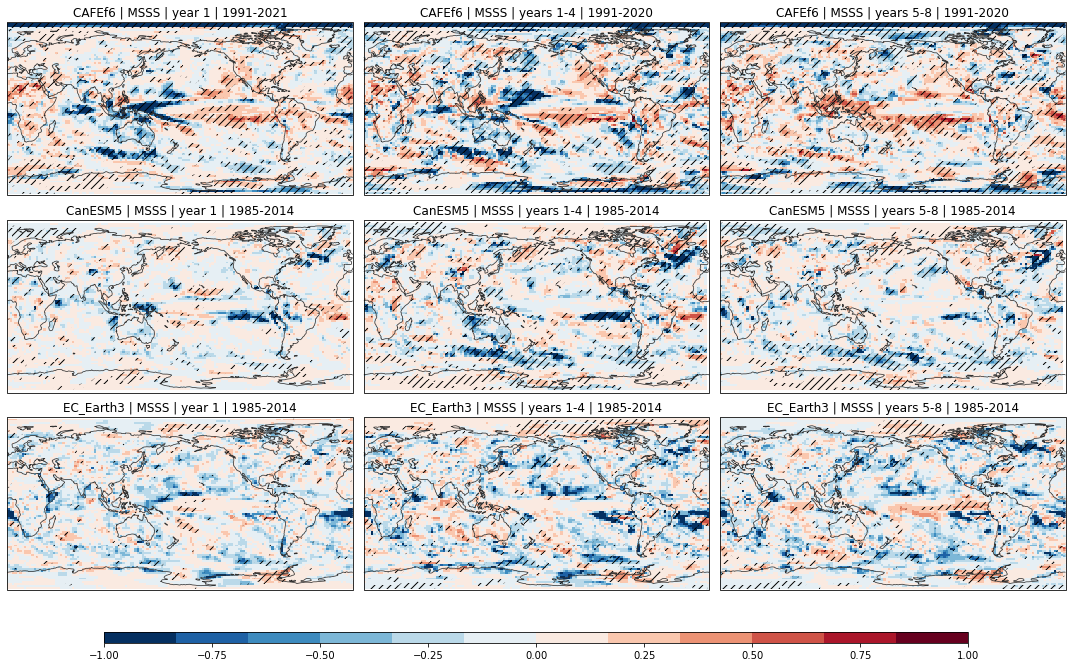

In [87]:
_ = plot_skill_maps(["CAFEf6", "CanESM5", "EC_Earth3"], "GPCP", "precip", "MSSS")

### Rank probability skill score relative to historical simulations | GPCP

In [ ]:
_ = plot_skill_maps(["CAFEf6", "CanESM5", "EC_Earth3"], "GPCP", "precip", "CRPSS")

## Upper ocean heat content (upper 300m)
### Anomaly correlation coefficient  |  EN.4.2.2

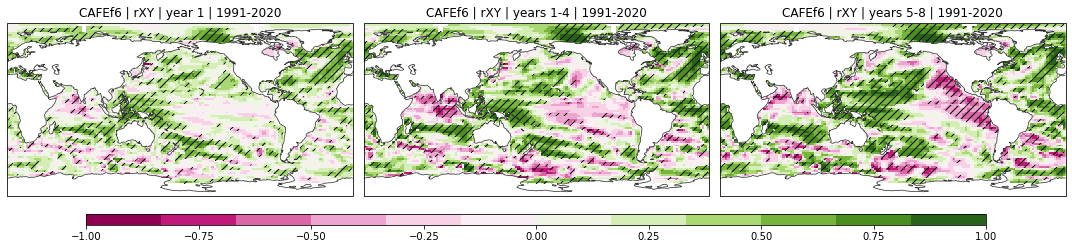

In [138]:
_ = plot_skill_maps(["CAFEf6"], "EN422", "ohc300", "rXY")

### Initialised component of the anomaly correlation coefficient | EN.4.2.2 
(see https://doi.org/10.1029/2019GL086361)

In [ ]:
_ = plot_skill_maps(["CAFEf6"], "EN422", "ohc300", "ri")

### Mean squared skill score relative to historical simulations | EN.4.2.2 

In [ ]:
_ = plot_skill_maps(["CAFEf6"], "EN422", "ohc300", "MSSS")

### Rank probability skill score relative to historical simulations | EN.4.2.2 

In [ ]:
_ = plot_skill_maps(["CAFEf6"], "EN422", "ohc300", "CRPSS")